# INSTRUCTIONS PROVIDED:

## PRODUCTION:
Dataset containing PLC information on the processing settings at COIL-DATE-MT level.
1. `COIL ID`: of the metal coil processed
1. `MT`:meter observation of the coil (i.e. one observation every 7 meters)
1. `DATE`: day of the year in which the processing of a given COIL-MT started
1. `TIME_START_PROCESS`: time in which the processing started 
1. All the remaining fields are settings refering to the processing of a given COIL-MT.

Hint: check the reliability of the MT variable.

## DEFECTS:
Dataset containing information on the detected defect by coil and type of defect.

This information are gathered during quality control processes after the production.
1. `COIL ID`: of the metal coil processed
1. `MT_FROM`: point of the coil in which a given defect start.
1. `MT_TO`: point in which a given defect end.
1. `DATE`: date in which the coil has been processed.
1. `DIF_TIPO_1`(to6): indicator for the kind of of defect detected.

In [22]:
#imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, make_scorer, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Memory
from sklearn.multioutput import MultiOutputClassifier
import csv
from xgboost import XGBClassifier
random_state = 42
test_size = 0.4
cachedir = Memory(location='cache_directory', verbose=0)

In [2]:
#loading data
path_production= '/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_PRODUCTION_clean.csv'
path_defects='/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_DEFECTS_clean.csv'
production = pd.read_csv(path_production)
defects = pd.read_csv(path_defects, sep=';')

Creating the `MT_REVIEWED` column and substitute with the `MT` for correcting the data issues

In [3]:
production.sort_values(by=['COIL', 'DATE', 'TIME_START_PROCESS'], inplace=True)
production['MT_REVIEWED'] = production.groupby(['COIL'])['MT'].transform(lambda x: np.arange(start=0, stop=len(x)*7, step=7))
production.drop(columns=['MT'], inplace=True)
column_change=production.pop('MT_REVIEWED')
production.insert(2, 'MT_REVIEWED',column_change)
production.head()

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


## Merging 2 dataframes
For the merging we looked for keeping all the rows of the production df

In [4]:
# This code creates the new dataframe with the defect information applied to the relevant meter ranges.
merged_df = production.copy()
for i in range(1, 7):
    defect_col = f'DIF_TIPO_{i}'
    merged_df[defect_col] = 0 # or use np.nan, or 0, depending on how you want to represent no defect

def apply_defects(row, production, merged_df):
    coil_id = row['COIL']
    mt_from = row['MT_FROM']
    mt_to = row['MT_TO']
    defect_info = row[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
    
    # Filter production for the current coil and meter range
    mask = (production['COIL'] == coil_id) & (production['MT_REVIEWED'] >= mt_from) & (production['MT_REVIEWED'] <= mt_to)
    production_subset = production.loc[mask]
    
    # Update the merged DataFrame with defect information
    for index in production_subset.index:
        merged_df.loc[index, defect_info.index] = defect_info.values

# Apply defects to the production DataFrame
_=defects.apply(lambda row: apply_defects(row, production, merged_df), axis=1)

## Creating DEFECT column for target

In [5]:
defect_columns = ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']
merged_df['DEFECT'] = merged_df[defect_columns].any(axis=1).astype(int)
print(merged_df.shape)
merged_df['DEFECT'].sum()

(299384, 117)


106132

### Dropping NaN values

In [6]:
# nan_counts = merged_df.isnull().sum()
# columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
# dropped_df = merged_df.dropna(subset=columns_with_nans)
# dropped_df

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6,DEFECT
170,243941,2019-03-06,28,00:02:59.070,23.610352,1273.28850,1279.944000,1281.003750,1280.850750,1313.777250,...,0.035063,0.258854,0.134993,0,0,0,0,0,0,0
171,243941,2019-03-06,35,00:03:14.070,23.570531,1272.81000,1280.896875,1282.756875,1280.227500,1310.394375,...,0.026615,0.258924,0.135011,0,0,0,0,0,0,0
172,243941,2019-03-06,42,00:03:44.070,23.591655,1272.04650,1280.596500,1283.728500,1280.731500,1309.549500,...,0.034612,0.258888,0.135006,0,0,0,0,0,0,0
173,243941,2019-03-06,49,00:03:59.070,23.583060,1270.78875,1279.190250,1284.021000,1280.661750,1308.818250,...,0.039367,0.258924,0.135024,0,0,0,0,0,0,0
174,243941,2019-03-06,56,00:04:14.070,23.594212,1269.96750,1277.968125,1284.232500,1281.303750,1308.823125,...,0.038277,0.258899,0.135018,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299365,6838679,2019-04-19,749,10:46:32.860,8.932843,1271.34000,1277.043750,1259.679375,1262.975625,1276.233750,...,0.034937,0.258947,0.135017,0,0,0,0,0,0,0
299366,6838679,2019-04-19,756,10:47:32.860,8.948430,1267.99875,1278.011250,1261.586250,1267.042500,1278.022500,...,0.038531,0.258911,0.134953,0,0,0,0,0,0,0
299367,6838679,2019-04-19,763,10:48:17.860,8.951884,1269.88875,1279.816875,1264.786875,1270.957500,1283.366250,...,0.038778,0.258913,0.135053,0,0,0,0,0,0,0
299368,6838679,2019-04-19,770,10:49:17.860,8.977444,1266.59250,1280.936250,1265.782500,1271.475000,1285.683750,...,0.035091,0.258892,0.135005,0,0,0,0,0,0,0


In [6]:
X=merged_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
print(X.shape)
X.head()

(299384, 106)


,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,PYRO_2_FRST_3_ZONE,PYRO_3_LST_3_ZONE,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,734.603062,549.3825,667.890562,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,727.025625,549.3825,668.464875,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,724.035750,549.3825,667.828500,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,723.072375,549.3825,675.487125,548.112375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,724.168688,549.3825,696.461625,567.477562,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


Dropping columns with 0 variance

## DROPPING FEATURES with correlation

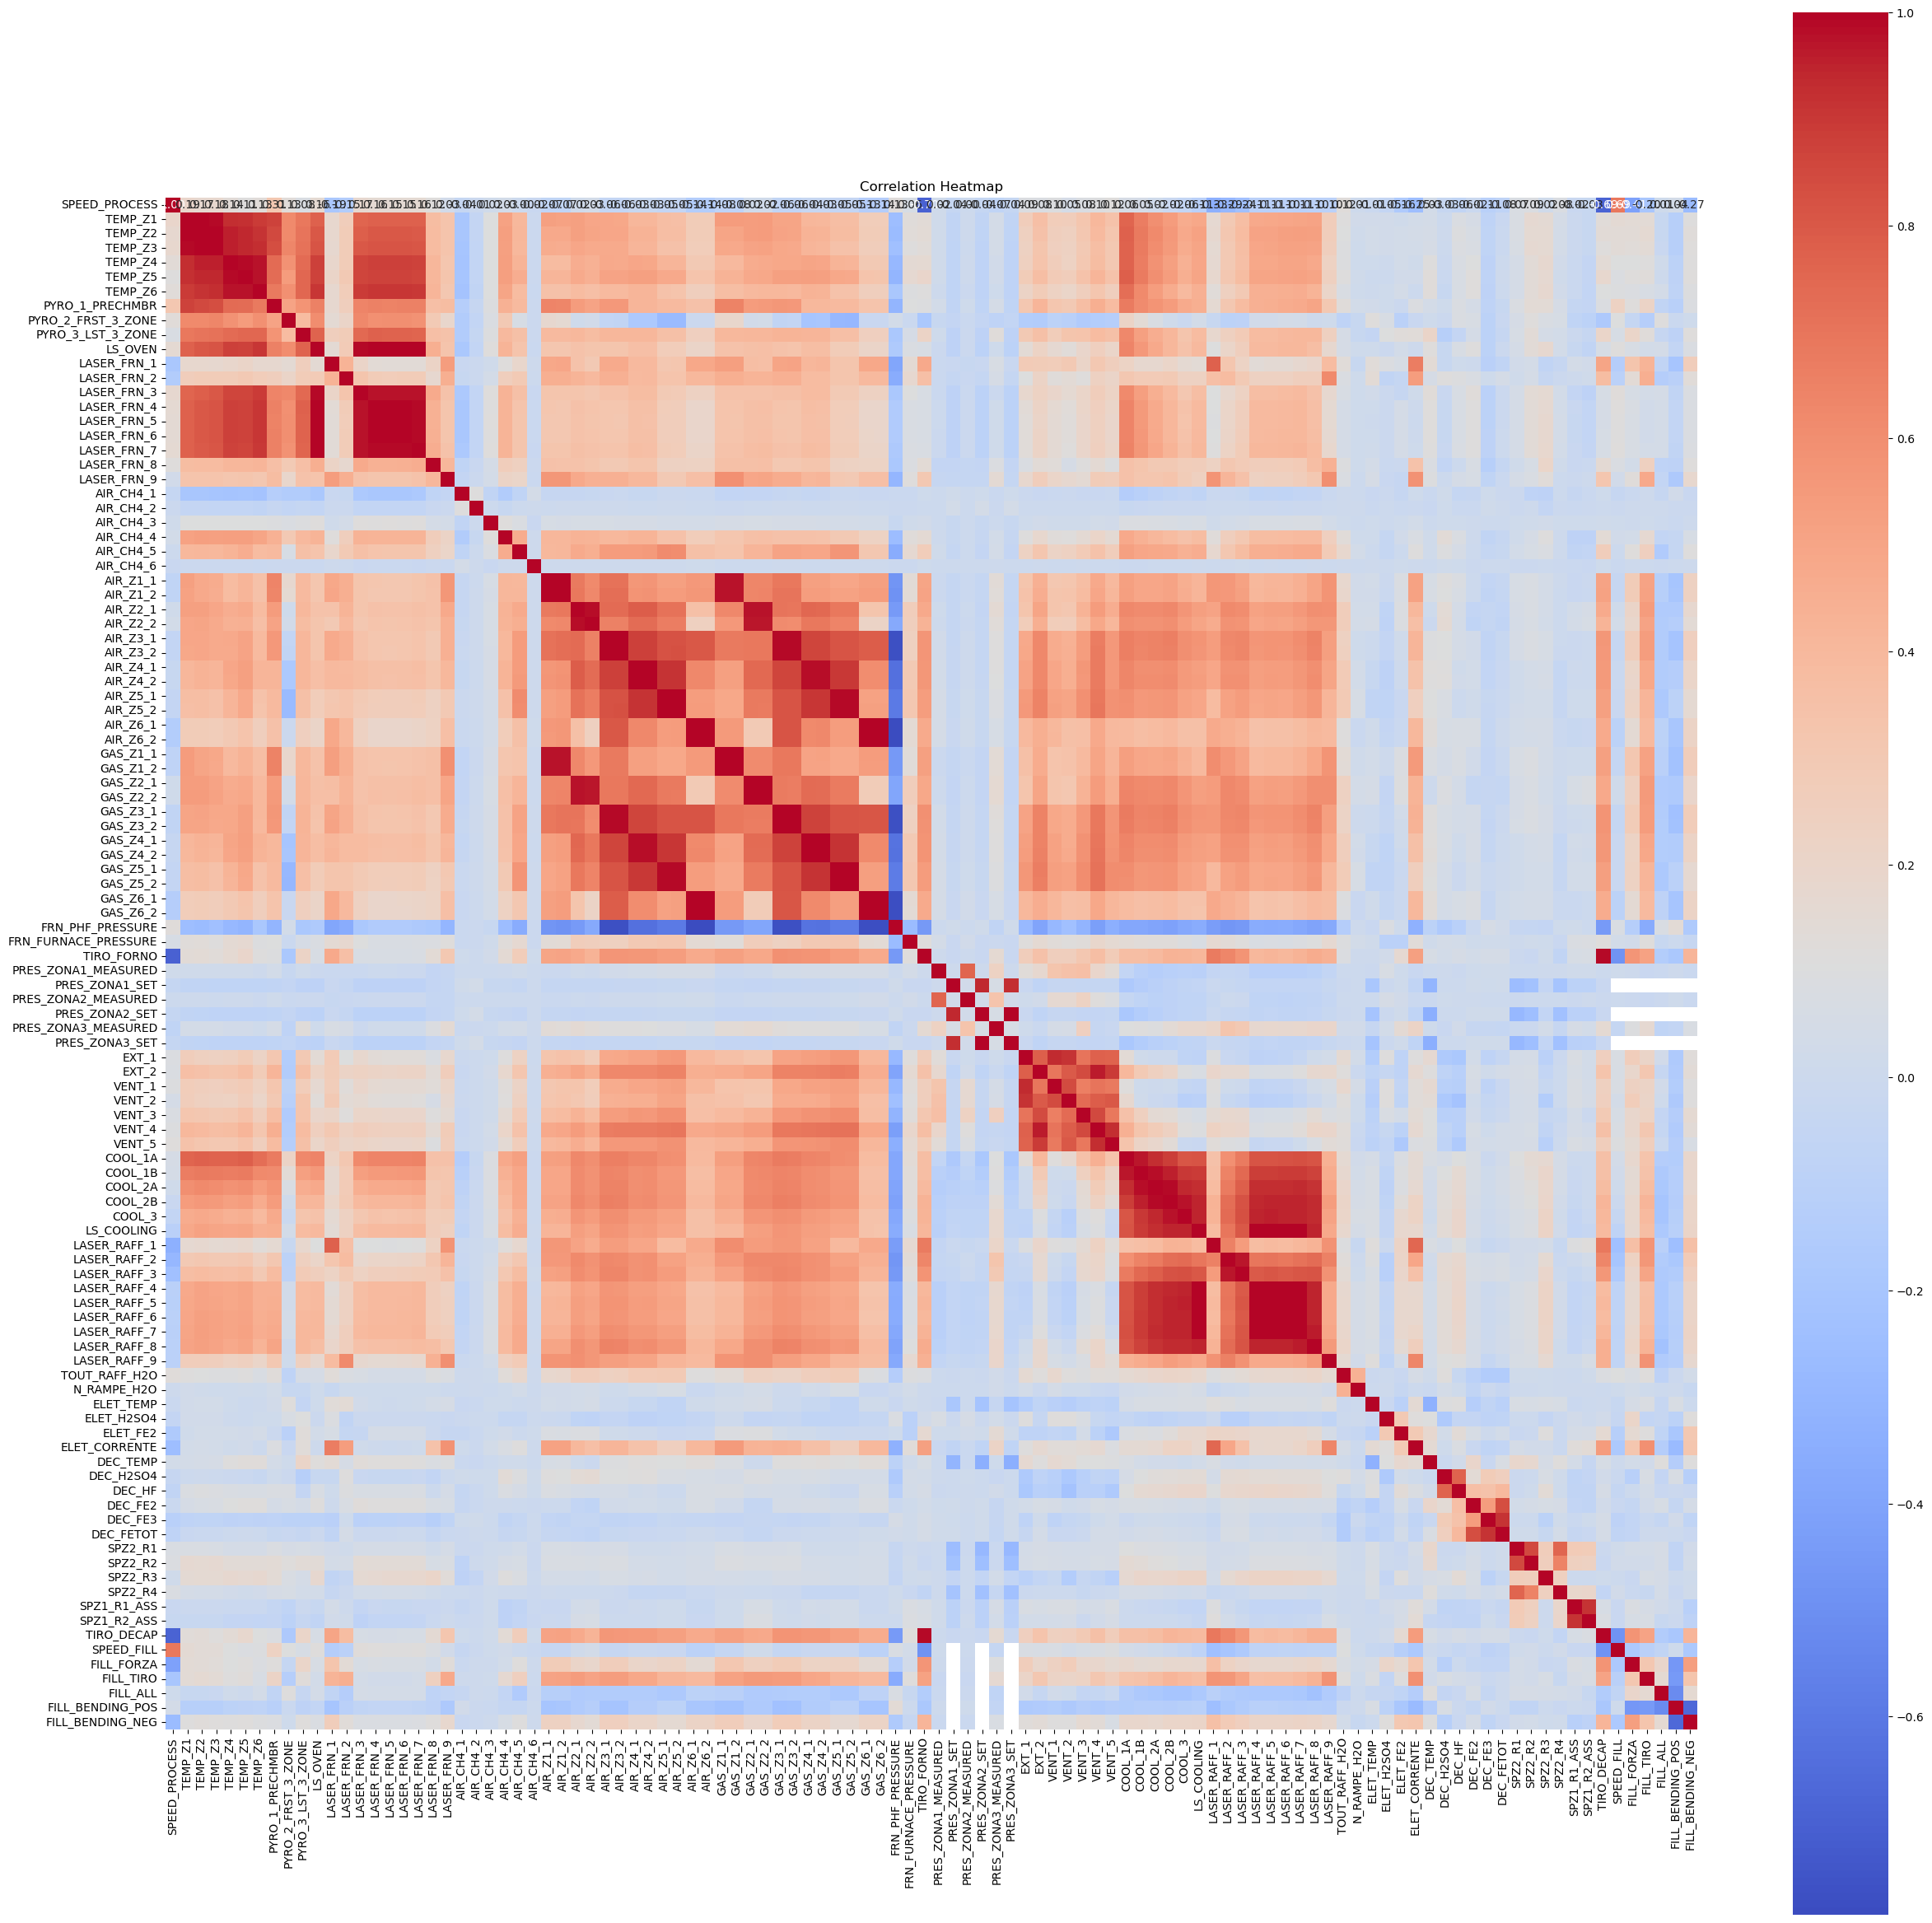

In [7]:
corr_matrix = X.corr()
plt.figure(figsize=(30, 30))  # You can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
corr_matrix = X.corr().abs()  # Take absolute value to consider both positive and negative correlations

# Step 2: Set a correlation threshold
threshold = .8

# Step 3: Identify highly correlated pairs
# We use a mask to avoid duplication and self-correlation (correlation of a feature with itself)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 4: Choose features to drop (we'll drop one of each pair)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Step 5: Drop the features
X_reduced = X.drop(columns=to_drop)
# X_reduced = X_reduced.drop(['PRES_ZONA3_SET', 'PRES_ZONA1_SET', 'PRES_ZONA2_SET'], axis=1)
X_reduced.shape

(299384, 51)

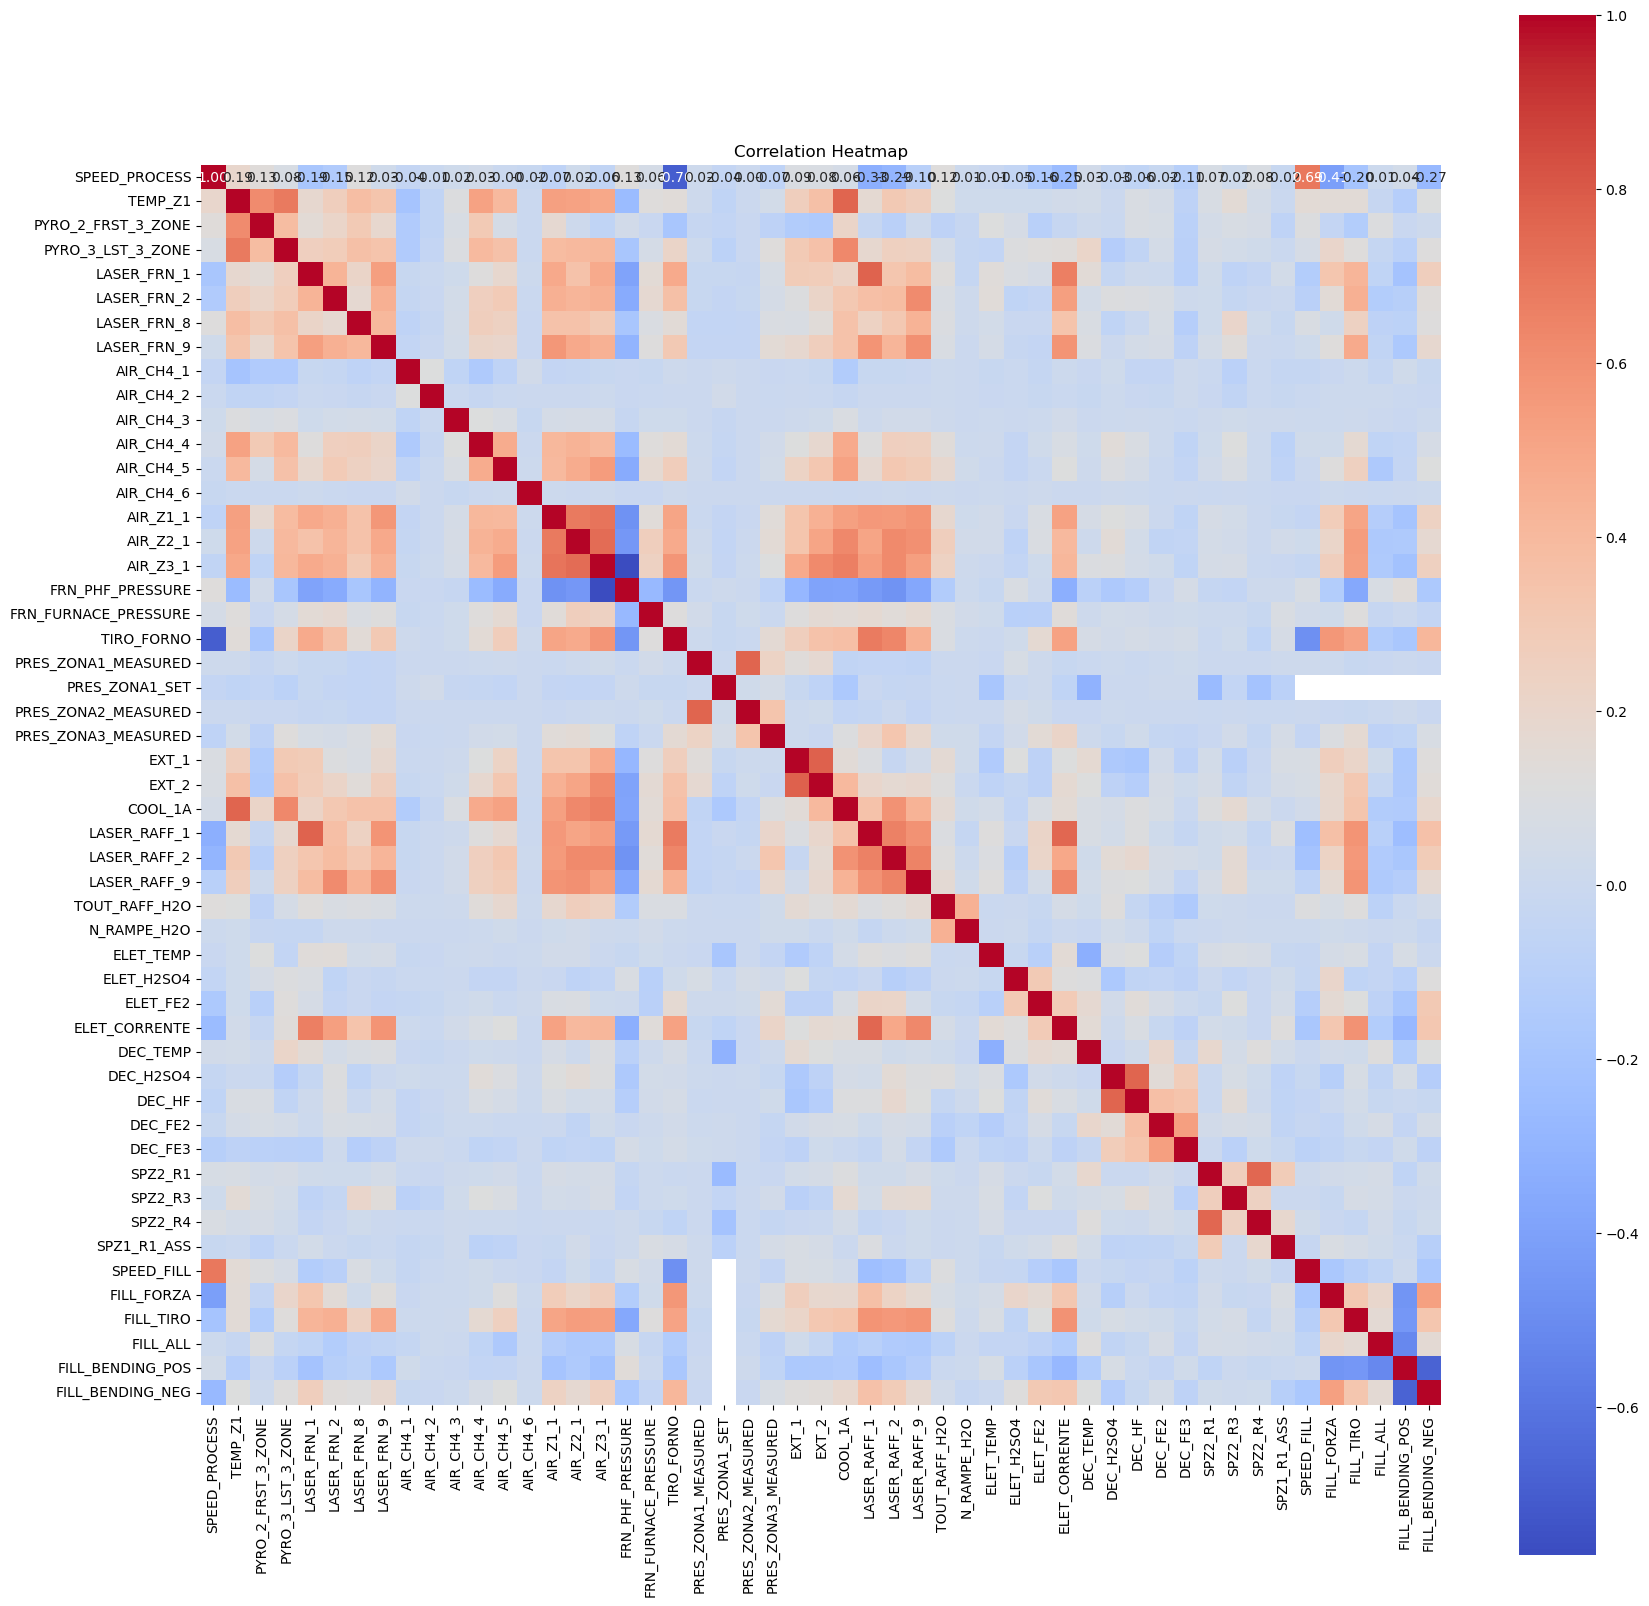

In [12]:
corr_matrix = X_reduced.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))  # You can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

## Splitting into Training, Validation and Test

In [64]:
target_columns = ['DEFECT']

# X = X_reduced
X=merged_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
y = merged_df[target_columns]
print(X.shape)
print(y.shape)
grouped = merged_df.groupby('COIL').groups

grouped_indices = [grouped[key] for key in grouped]

train_indices, temp_indices = train_test_split(grouped_indices, test_size=0.4, random_state=random_state)

validate_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=random_state)

train_indices = [index for sublist in train_indices for index in sublist]
validate_indices = [index for sublist in validate_indices for index in sublist]
test_indices = [index for sublist in test_indices for index in sublist]

X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_val, y_val = X.iloc[validate_indices], y.iloc[validate_indices]
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

(299384, 106)
(299384, 1)


In [65]:
coil_to_dataset = {}

for coil_id in merged_df['COIL'].unique():
    if coil_id in merged_df.loc[train_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'train'
    elif coil_id in merged_df.loc[validate_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'validate'
    elif coil_id in merged_df.loc[test_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'test'
from collections import defaultdict
coil_datasets = defaultdict(list)

for coil_id, dataset in coil_to_dataset.items():
    coil_datasets[coil_id].append(dataset)
duplicates = {coil_id: datasets for coil_id, datasets in coil_datasets.items() if len(datasets) > 1}
if duplicates:
    print("Duplicate COIL IDs found in multiple datasets:", duplicates)
else:
    print("No duplicate COIL IDs found. The split is correct.")


No duplicate COIL IDs found. The split is correct.


In [67]:
print('There are {} samples in the training dataset which represent the {:.2f}%'.format(X_train.shape[0], X_train.shape[0]/merged_df.shape[0]*100))
print("There are {} samples in the validating dataset which represent the {:.2f}%".format(X_val.shape[0], X_val.shape[0]/merged_df.shape[0]*100))
print("There are {} samples in the testing dataset which represent the {:.2f}%".format(X_test.shape[0], X_test.shape[0]/merged_df.shape[0]*100))
print("Each sample has {} features".format(X_train.shape[1]))
print(f"Unique COIL values in 'production' dataset: {production['COIL'].nunique()}")
print(f"Unique COIL values in 'merged_df' dataset: {merged_df['COIL'].nunique()}")

There are 179813 samples in the training dataset which represent the 60.06%
There are 56625 samples in the validating dataset which represent the 18.91%
There are 62946 samples in the testing dataset which represent the 21.03%
Each sample has 106 features
Unique COIL values in 'production' dataset: 1261
Unique COIL values in 'merged_df' dataset: 1261


### Binary target

In [20]:
# Define a smaller parameter grid
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
}

# Initialize the XGBClassifier
xgb_classifier = XGBClassifier(random_state=random_state)

# Initialize RandomizedSearchCV with the XGBClassifier and the parameter distribution
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,  # Reduced number of cross-validation folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=random_state,
    verbose=2
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and the corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score:.4f}")

# You can use the best estimator directly to make predictions or further analysis
best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   4.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   4.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   4.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   5.6s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   5.7s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9; total time=   6.0s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   8.5s
[CV] END 

In [23]:
# Evaluate the model on the training set
train_predictions = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions, average='macro')
train_precision = precision_score(y_train, train_predictions, average='macro')
train_f1 = f1_score(y_train, train_predictions, average='macro')
train_log_loss = log_loss(y_train, best_model.predict_proba(X_train))

print("Train Accuracy:", train_accuracy)
print("Train Recall:", train_recall)
print("Train Precision:", train_precision)
print("Train F1 Score:", train_f1)
print("Train Log Loss:", train_log_loss)

# Evaluate the model on the validation set
val_predictions = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions, average='macro')
val_precision = precision_score(y_val, val_predictions, average='macro')
val_f1 = f1_score(y_val, val_predictions, average='macro')
val_log_loss = log_loss(y_val, best_model.predict_proba(X_val))

print("Validation Accuracy:", val_accuracy)
print("Validation Recall:", val_recall)
print("Validation Precision:", val_precision)
print("Validation F1 Score:", val_f1)
print("Validation Log Loss:", val_log_loss)

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions, average='macro')
test_precision = precision_score(y_test, test_predictions, average='macro')
test_f1 = f1_score(y_test, test_predictions, average='macro')
test_log_loss = log_loss(y_test, best_model.predict_proba(X_test))

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)
print("Test Log Loss:", test_log_loss)

# Confusion Matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Test Confusion Matrix:\n", test_confusion_matrix)

Train Accuracy: 0.9100732427577539
Train Recall: 0.9054310846170022
Train Precision: 0.9000023449588541
Train F1 Score: 0.9025754886914588
Train Log Loss: 0.2495658946635131
Validation Accuracy: 0.7699426048565121
Validation Recall: 0.7497182180461204
Validation Precision: 0.7576895779977434
Validation F1 Score: 0.7530105375376928
Validation Log Loss: 0.4301385536660129
Test Accuracy: 0.8310456581832046
Test Recall: 0.8025595386625285
Test Precision: 0.8090074844865021
Test F1 Score: 0.8056008905918957
Test Log Loss: 0.3595860029208668
Test Confusion Matrix:
 [[37542  4919]
 [ 5716 14769]]


In [25]:
results = pd.DataFrame({
    'Actual': y_test['DEFECT'],
    'Predicted': test_predictions
})
results = results.join(merged_df[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']])
conditions = [
    (results['Actual'] == 1) & (results['Predicted'] == 1),  # True Positive
    (results['Actual'] == 0) & (results['Predicted'] == 0),  # True Negative
    (results['Actual'] == 0) & (results['Predicted'] == 1),  # False Positive
    (results['Actual'] == 1) & (results['Predicted'] == 0)   # False Negative
]
choices = ['TP', 'TN', 'FP', 'FN']
results['Category'] = np.select(conditions, choices)
defect_distribution = results.groupby('Category')[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']].sum()
defect_distribution

,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
Category,,,,,,
FN,207,1218,4513,3391,89,364
FP,0,0,0,0,0,0
TN,0,0,0,0,0,0
TP,1100,848,13167,7476,505,1554


In [26]:
# Check the distribution of the actual classes
print("Distribution of actual classes:")
print(y_test['DEFECT'].value_counts())

# Check the distribution of the predicted classes
print("\nDistribution of predicted classes:")
print(pd.Series(test_predictions).value_counts())

# Check the first few instances to ensure alignment
print("\nFirst few actual and predicted values:")
print(pd.DataFrame({'Actual': y_test['DEFECT'], 'Predicted': test_predictions}).head())


Distribution of actual classes:
DEFECT
0    42461
1    20485
Name: count, dtype: int64

Distribution of predicted classes:
0    43258
1    19688
Name: count, dtype: int64

First few actual and predicted values:
        Actual  Predicted
225503       0          1
225504       0          1
225505       0          1
225506       0          1
225507       0          1


## Built-in Feature Importance
Most tree-based models in libraries like scikit-learn have a built-in feature_importances_ attribute after the model has been fitted. This provides a simple way to see the relative importance of each feature

In [60]:
feature_importances = best_model.feature_importances_
f_sel=6
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(f"The sum of all the features is {feature_importances_df['Importance'].sum()}")
print(f"The sum of importances for the top {f_sel} features is {feature_importances_df['Importance'].head(f_sel).sum()}")
feature_importances_df.head(10)


The sum of all the features is 1.0
The sum of importances for the top 6 features is 0.34095892310142517


,Feature,Importance
6,TEMP_Z6,0.098985
67,COOL_1B,0.075555
5,TEMP_Z5,0.060774
43,GAS_Z3_2,0.040678
2,TEMP_Z2,0.035581
1,TEMP_Z1,0.029386
45,GAS_Z4_2,0.028848
4,TEMP_Z4,0.023866
74,LASER_RAFF_3,0.023793
44,GAS_Z4_1,0.023169


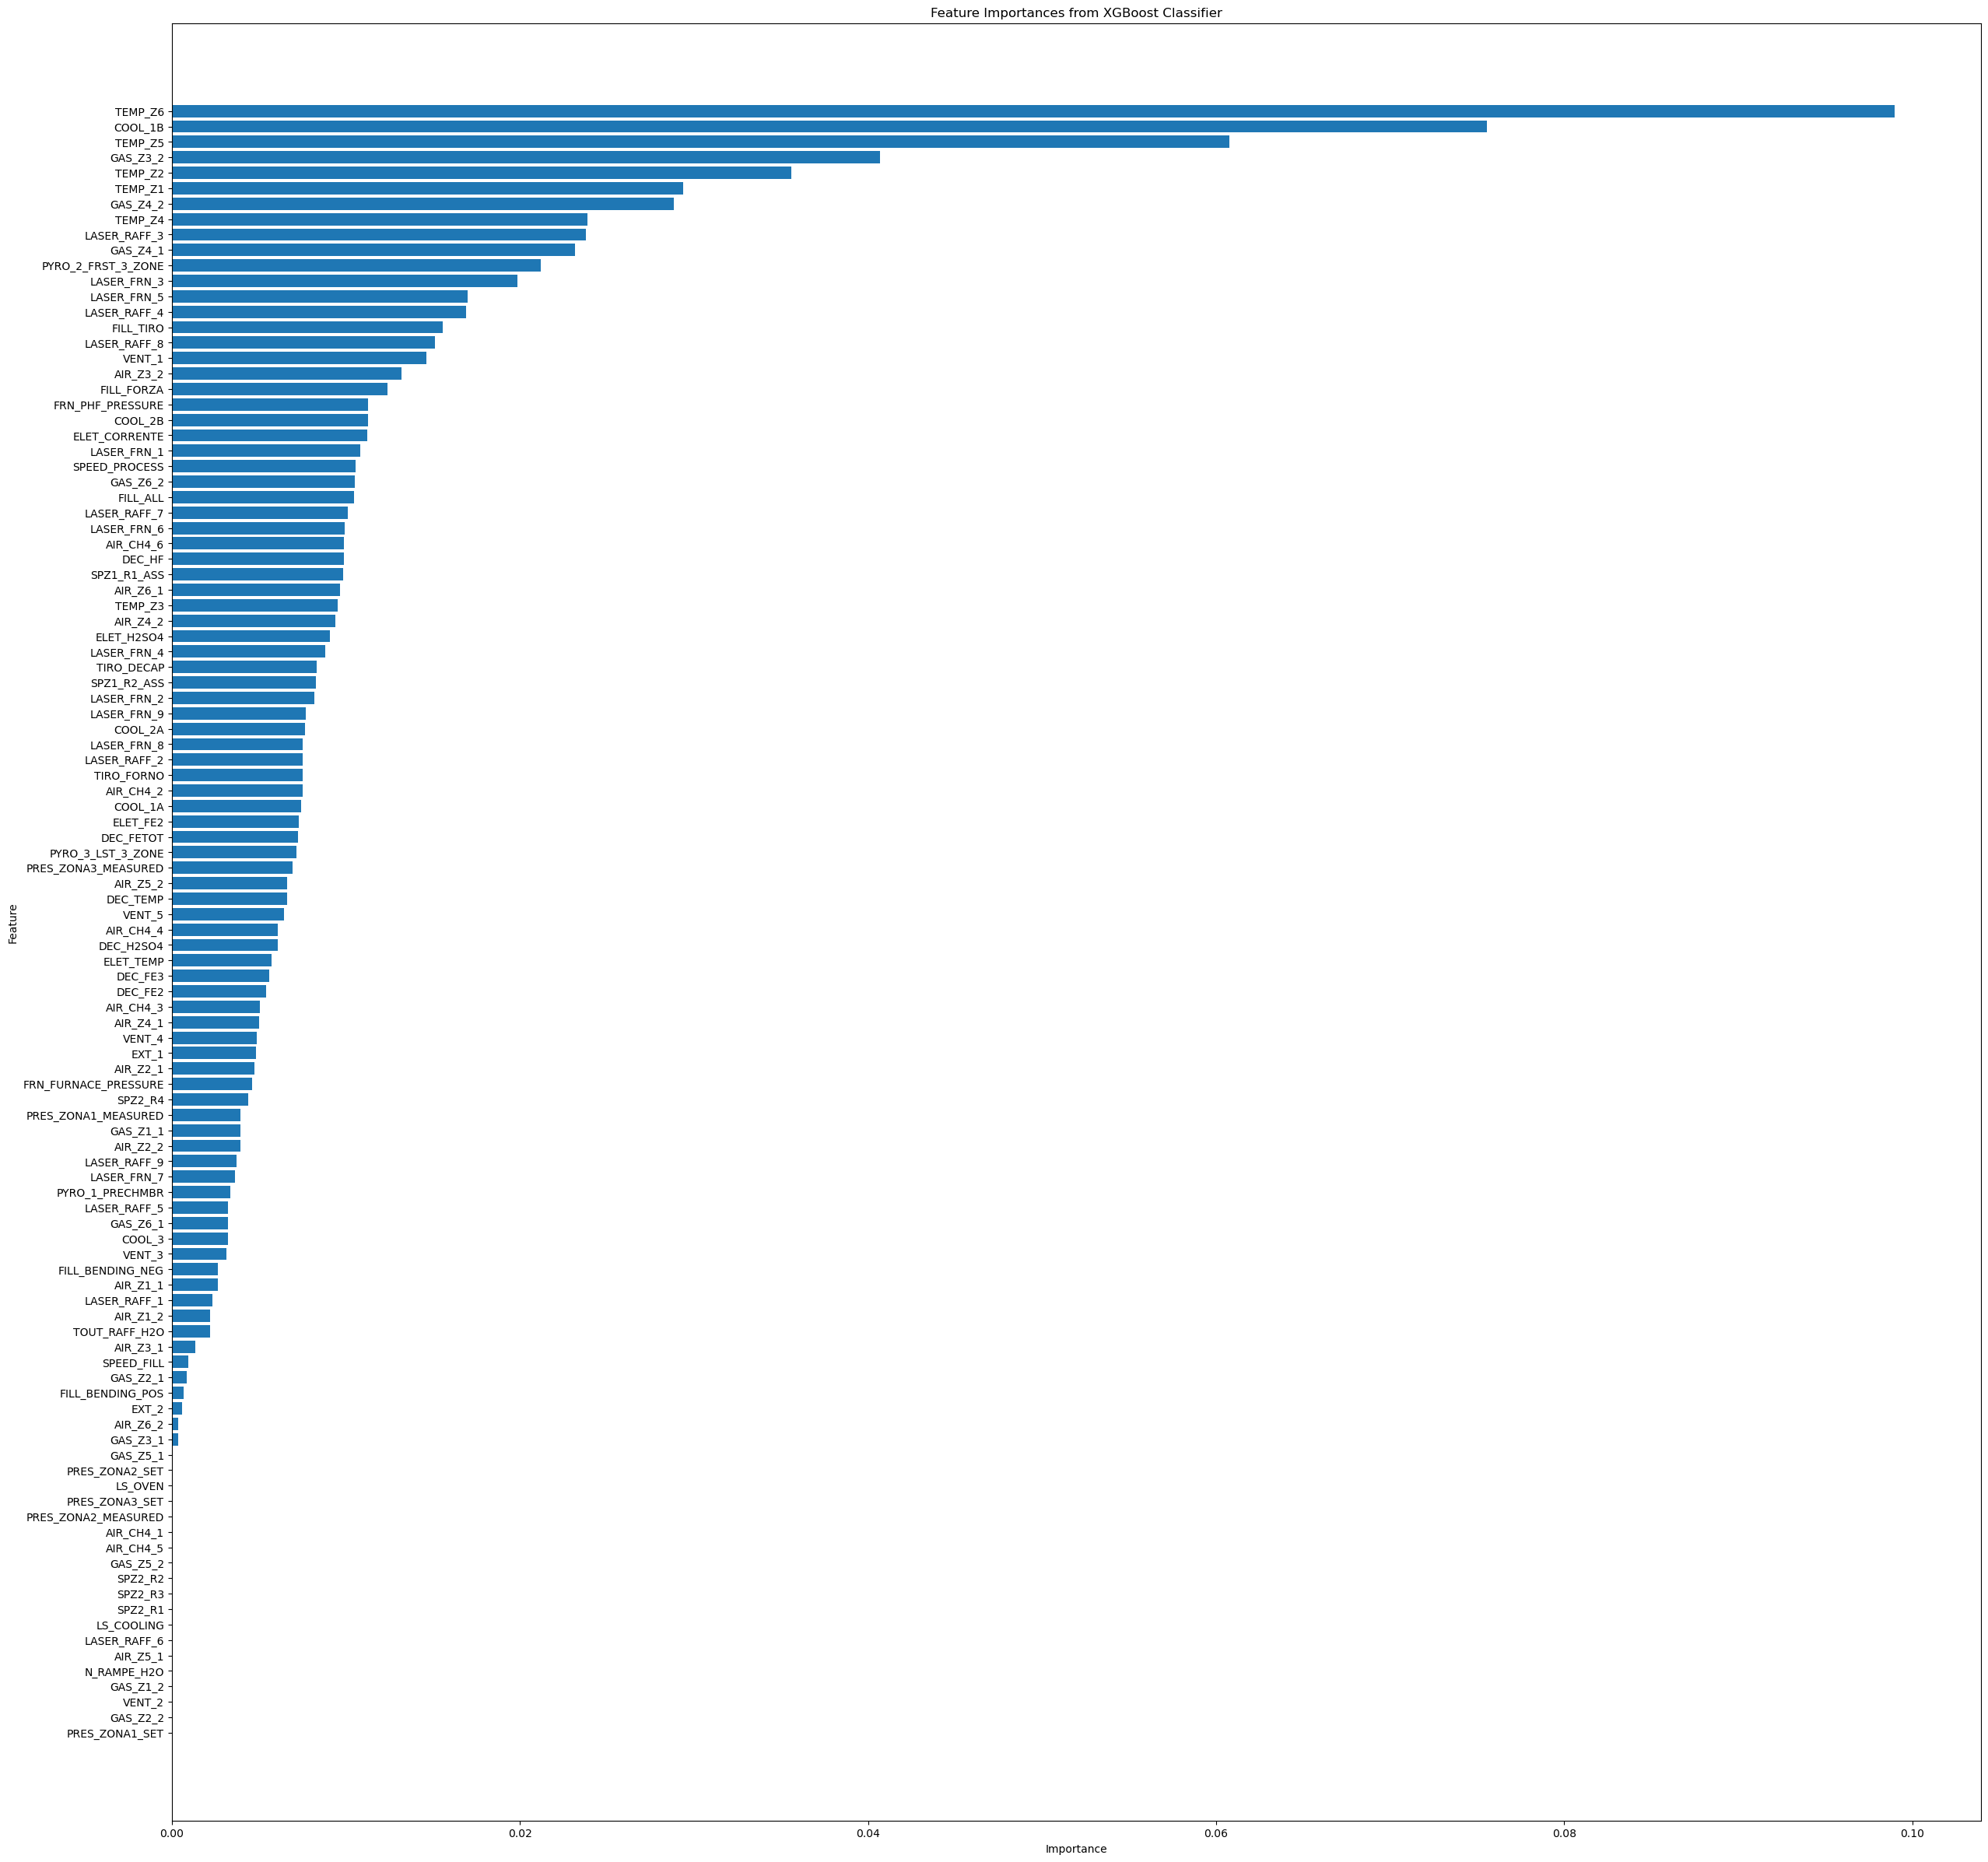

In [61]:
plt.figure(figsize=(30, 30))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

In [29]:
defects_df = merged_df[merged_df['DEFECT'] == 1]
print(defects_df.shape)
no_defects_df = merged_df[merged_df['DEFECT'] == 0]
print(no_defects_df.shape)

(106132, 117)
(193252, 117)


In [62]:
# Assuming 'feature_importances_df' is sorted by importance in descending order
# Get the names of the top 6 features
top_features = feature_importances_df['Feature'].head(f_sel)

# Initialize a dictionary to hold the statistics for each feature
feature_stats = {'Statistic': ['Min', 'Max', 'Mean', 'Median', 'Mode']}

# Define a function to calculate statistics for a given DataFrame and feature
def calculate_stats(df, feature):
    min_value = df[feature].min()
    max_value = df[feature].max()
    mean_value = df[feature].mean()
    median_value = df[feature].median()
    mode_value = df[feature].mode()[0]  # Mode could be multiple values; take the first one
    return [min_value, max_value, mean_value, median_value, mode_value]

# Loop over the top 6 features to calculate statistics for both DataFrames
for feature in top_features:
    feature_stats[f'{feature} No Defects'] = calculate_stats(no_defects_df, feature)
    feature_stats[f'{feature} Defects'] = calculate_stats(defects_df, feature)

# Create a DataFrame from the dictionary of statistics
stats_df = pd.DataFrame(feature_stats)

# Display the DataFrame
stats_df

,Statistic,TEMP_Z6 No Defects,TEMP_Z6 Defects,COOL_1B No Defects,COOL_1B Defects,TEMP_Z5 No Defects,TEMP_Z5 Defects,GAS_Z3_2 No Defects,GAS_Z3_2 Defects,TEMP_Z2 No Defects,TEMP_Z2 Defects,TEMP_Z1 No Defects,TEMP_Z1 Defects
0,Min,79.205925,267.988500,22.500000,22.500000,78.567278,268.998750,-1.495564,-6.243480,74.225453,257.701050,79.722742,262.855125
1,Max,1362.465000,1362.536250,888.621750,893.760975,1367.288438,1357.942500,336.219750,336.357000,1344.982500,1339.344000,1322.268750,1320.543750
2,Mean,1272.617338,1297.454358,672.682146,733.207100,1282.360498,1314.116866,180.586039,239.405926,1243.609142,1283.077681,1223.142224,1260.480439
3,Median,1292.369891,1311.682500,697.459179,736.327731,1293.555536,1332.056250,179.385188,252.017888,1260.443411,1293.126890,1237.871250,1269.641250
4,Mode,1293.243750,1316.643750,22.500000,759.988125,1337.861250,1333.293750,142.672500,332.311500,1259.921250,1293.795000,1236.712500,1270.383750


/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

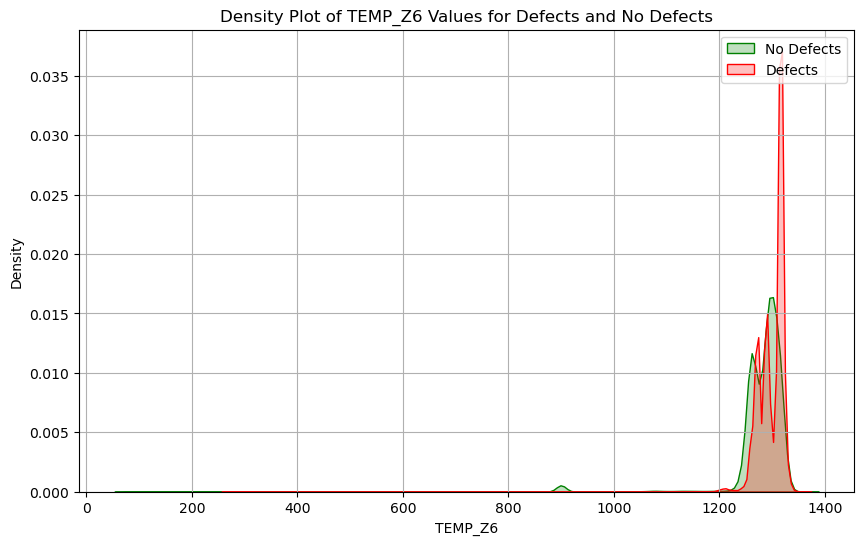

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

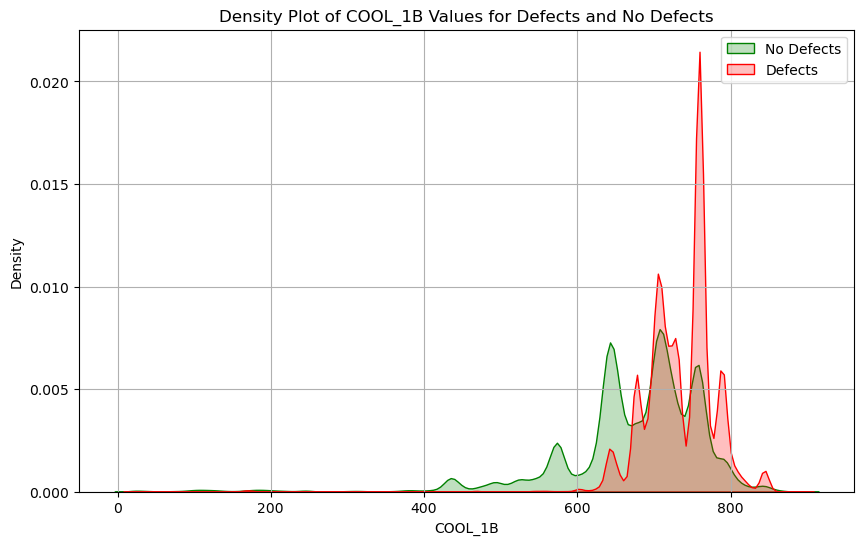

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

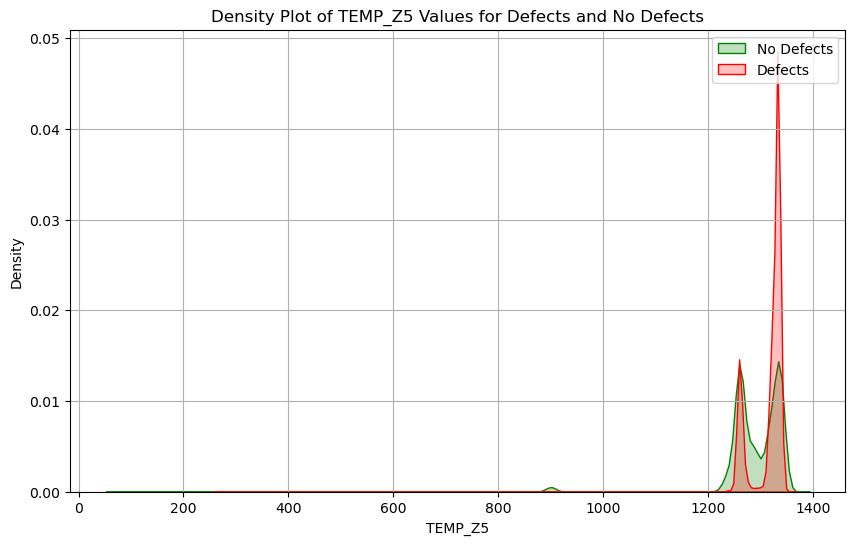

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

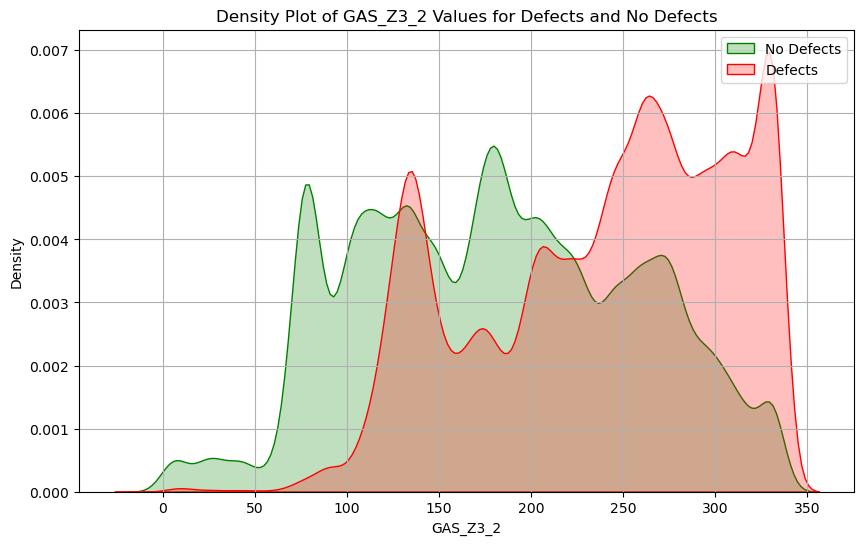

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

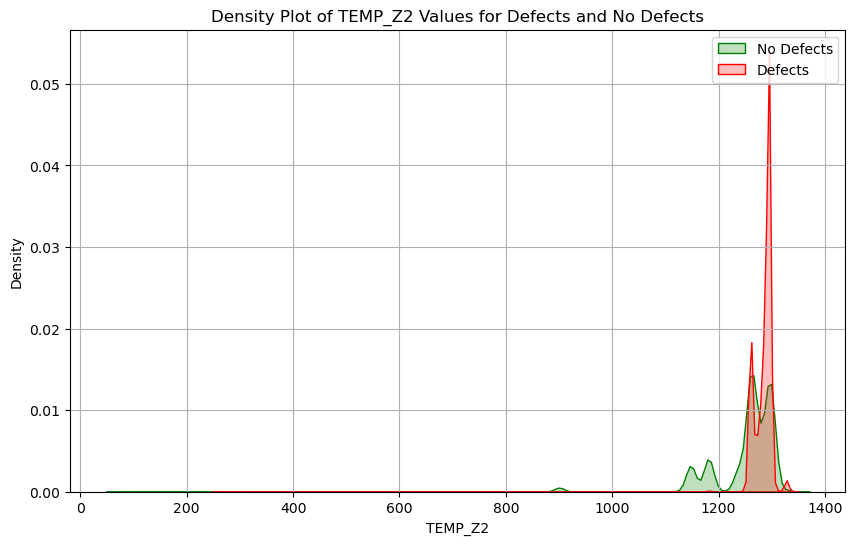

/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_0/7vfs2cbn3wlds_6c9t8rrhhm0000gn/T/ipykernel_61058/2646603015.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

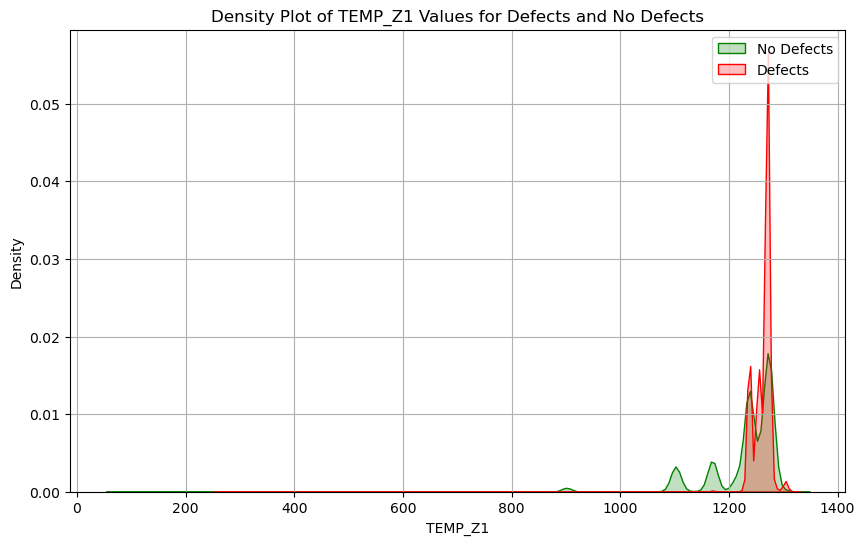

In [63]:
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(no_defects_df[feature], shade=True, color='green', label='No Defects')
    sns.kdeplot(defects_df[feature], shade=True, color='red', label='Defects')
    plt.title(f'Density Plot of {feature} Values for Defects and No Defects')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
